<a href="https://colab.research.google.com/github/vikasg964/Stock_price_forcasting/blob/main/Time_forcasting_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

Helper Functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

Reading the dataset

In [ ]:
df_stock = pd.read_csv('/content/CSC215_P2_Stock_Price.csv')

In [ ]:
df_stock.head

<bound method NDFrame.head of            Date        Open        High  ...   Adj_Close   Volume           y
0     2000/3/27    3.812500    4.156250  ...    4.125000  3675600    4.125000
1     2000/3/28    4.125000    4.125000  ...    4.015625  1077600    4.015625
2     2000/3/29    4.000000    4.031250  ...    4.000000   437200    4.000000
3     2000/3/30    4.000000    4.000000  ...    3.843750  1883600    3.843750
4     2000/3/31    3.734375    3.734375  ...    3.390625  7931600    3.390625
...         ...         ...         ...  ...         ...      ...         ...
4387   2017/9/1  113.790001  114.099998  ...  113.309998   950000  113.309998
4388   2017/9/5  112.519997  113.529999  ...  111.870003  1805200  111.870003
4389   2017/9/6  112.029999  112.489998  ...  112.230003  2136700  112.230003
4390   2017/9/7  112.459999  112.900002  ...  112.339996  1251600  112.339996
4391   2017/9/8  112.300003  114.790001  ...  113.190002  1611700  113.190002

[4392 rows x 8 columns]>

In [ ]:
df_stock.shape

(4392, 8)

Drop date and Adj_close

In [ ]:

# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,y
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600,4.125000
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600,4.015625
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200,4.000000
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600,3.843750
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600,3.390625


In [ ]:
df_stock_new.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
y            0
dtype: int64

In [ ]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


In [ ]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [ ]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


Normalize the columns

In [ ]:
#Normalizing except  last column y
for column in df_stock_new.columns:
  if  column != 'y':
    encode_numeric_zscore(df_stock_new, column)

#print first  5 rows in new csv file to check for normalizing
print(df_stock_new.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [ ]:
# Set all column other than y as input or 'x'
x = df_stock_new.iloc[:,df_stock_new.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_stock_new['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


Data Transformation

In [ ]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array
x_newseq=x_lstseq.reshape(4385,35)

Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)


In [ ]:

x_seq_2d = x_lstseq.reshape(4385,35)

Split the data into 70 and 30

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_2d,y_lstseq,test_size=0.30,random_state=0)

In [ ]:

X_train.shape

(3069, 35)

In [ ]:

X_test.shape

(1316, 35)

In [ ]:

Y_train.shape

(3069,)

In [ ]:

Y_test.shape

(1316,)

In [ ]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

Applying Neutral networks

In [ ]:
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers




Model trained for "adam" optimizer and "relu" activation function : 

Epoch 1/200
96/96 - 0s - loss: 888.9897 - val_loss: 165.8084
Epoch 2/200
96/96 - 0s - loss: 139.2051 - val_loss: 112.7738
Epoch 3/200
96/96 - 0s - loss: 81.1216 - val_loss: 51.7107
Epoch 4/200
96/96 - 0s - loss: 28.5912 - val_loss: 15.0419
Epoch 5/200
96/96 - 0s - loss: 8.9379 - val_loss: 6.7603
Epoch 6/200
96/96 - 0s - loss: 3.7840 - val_loss: 4.1754
Epoch 7/200
96/96 - 0s - loss: 2.3563 - val_loss: 2.7377
Epoch 8/200
96/96 - 0s - loss: 2.0838 - val_loss: 3.3391
Epoch 9/200
96/96 - 0s - loss: 1.6336 - val_loss: 2.2378
Epoch 10/200
96/96 - 0s - loss: 1.3775 - val_loss: 2.4594
Epoch 11/200
96/96 - 0s - loss: 1.3761 - val_loss: 3.8735
Epoch 12/200
96/96 - 0s - loss: 1.4605 - val_loss: 1.8221
Epoch 13/200
96/96 - 0s - loss: 1.1176 - val_loss: 1.7338
Epoch 14/200
96/96 - 0s - loss: 1.4551 - val_loss: 3.4417
Epoch 15/200
96/96 - 0s - loss: 1.2263 - val_loss: 1.5196
Epoch 16/200
96/96 - 0s - loss: 1.2303 - val_loss: 1.4

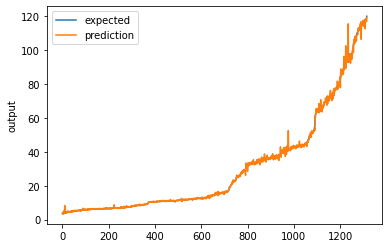




Model trained for "adam" optimizer and "sigmoid" activation function : 

Epoch 1/200
96/96 - 0s - loss: 1640.8074 - val_loss: 1485.7268
Epoch 2/200
96/96 - 0s - loss: 1438.4329 - val_loss: 1347.3582
Epoch 3/200
96/96 - 0s - loss: 1327.6774 - val_loss: 1257.8425
Epoch 4/200
96/96 - 0s - loss: 1246.4604 - val_loss: 1186.2677
Epoch 5/200
96/96 - 0s - loss: 1178.6796 - val_loss: 1123.3062
Epoch 6/200
96/96 - 0s - loss: 1112.1813 - val_loss: 1051.0991
Epoch 7/200
96/96 - 0s - loss: 1041.5436 - val_loss: 984.7750
Epoch 8/200
96/96 - 0s - loss: 977.3649 - val_loss: 923.9652
Epoch 9/200
96/96 - 0s - loss: 917.8549 - val_loss: 867.7321
Epoch 10/200
96/96 - 0s - loss: 862.7985 - val_loss: 814.6506
Epoch 11/200
96/96 - 0s - loss: 811.7101 - val_loss: 766.4515
Epoch 12/200
96/96 - 0s - loss: 764.6422 - val_loss: 721.6643
Epoch 13/200
96/96 - 0s - loss: 721.3213 - val_loss: 680.3837
Epoch 14/200
96/96 - 0s - loss: 681.2283 - val_loss: 642.4550
Epoch 15/200
96/96 - 0s - loss: 644.0010 - val_loss:

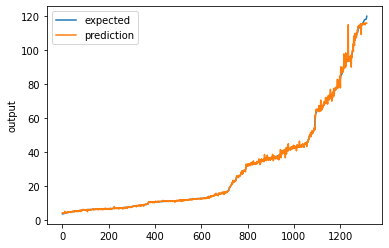




Model trained for "adam" optimizer and "tanh" activation function : 

Epoch 1/200
96/96 - 0s - loss: 1583.5714 - val_loss: 1301.7140
Epoch 2/200
96/96 - 0s - loss: 1205.5797 - val_loss: 1098.9038
Epoch 3/200
96/96 - 0s - loss: 1065.4764 - val_loss: 985.8232
Epoch 4/200
96/96 - 0s - loss: 960.5522 - val_loss: 891.2633
Epoch 5/200
96/96 - 0s - loss: 869.2566 - val_loss: 805.5768
Epoch 6/200
96/96 - 0s - loss: 789.6962 - val_loss: 731.6063
Epoch 7/200
96/96 - 0s - loss: 720.0066 - val_loss: 667.7745
Epoch 8/200
96/96 - 0s - loss: 658.8788 - val_loss: 611.4493
Epoch 9/200
96/96 - 0s - loss: 605.2319 - val_loss: 561.5588
Epoch 10/200
96/96 - 0s - loss: 557.7300 - val_loss: 518.1750
Epoch 11/200
96/96 - 0s - loss: 516.1539 - val_loss: 479.1587
Epoch 12/200
96/96 - 0s - loss: 479.5635 - val_loss: 446.1842
Epoch 13/200
96/96 - 0s - loss: 445.8321 - val_loss: 412.2814
Epoch 14/200
96/96 - 0s - loss: 412.3819 - val_loss: 381.1965
Epoch 15/200
96/96 - 0s - loss: 382.0890 - val_loss: 352.6872
E

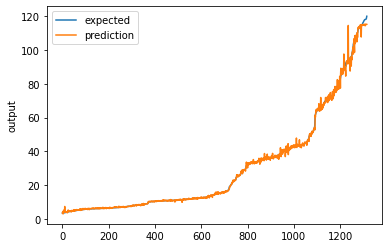




Model trained for "sgd" optimizer and "relu" activation function : 

Epoch 1/200
96/96 - 0s - loss: nan - val_loss: nan
Epoch 2/200
96/96 - 0s - loss: nan - val_loss: nan
Epoch 3/200
96/96 - 0s - loss: nan - val_loss: nan
Epoch 4/200
96/96 - 0s - loss: nan - val_loss: nan
Epoch 5/200
96/96 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 21360.341796875
Final score (RMSE): 146.1517791748047


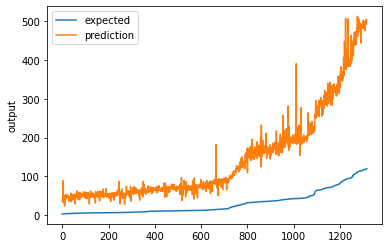




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Epoch 1/200
96/96 - 0s - loss: 268.2057 - val_loss: 50.2250
Epoch 2/200
96/96 - 0s - loss: 93.8504 - val_loss: 96.9063
Epoch 3/200
96/96 - 0s - loss: 83.7068 - val_loss: 50.9744
Epoch 4/200
96/96 - 0s - loss: 64.8906 - val_loss: 44.3444
Epoch 5/200
96/96 - 0s - loss: 55.1255 - val_loss: 38.1976
Epoch 6/200
96/96 - 0s - loss: 63.4300 - val_loss: 18.6000
Epoch 7/200
96/96 - 0s - loss: 72.7898 - val_loss: 61.4724
Epoch 8/200
96/96 - 0s - loss: 65.9526 - val_loss: 79.6957
Epoch 9/200
96/96 - 0s - loss: 55.2972 - val_loss: 51.3587
Epoch 10/200
96/96 - 0s - loss: 44.0219 - val_loss: 15.6895
Epoch 11/200
96/96 - 0s - loss: 36.3966 - val_loss: 49.1924
Epoch 12/200
96/96 - 0s - loss: 33.8584 - val_loss: 46.8418
Epoch 13/200
96/96 - 0s - loss: 17.9832 - val_loss: 11.1126
Epoch 14/200
96/96 - 0s - loss: 13.1400 - val_loss: 7.7902
Epoch 15/200
96/96 - 0s - loss: 7.5818 - val_loss: 4.5340
Epoch 16/200
96/96 - 0s - loss: 7.35

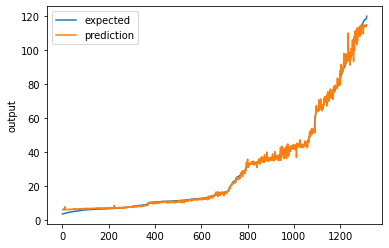




Model trained for "sgd" optimizer and "tanh" activation function : 

Epoch 1/200
96/96 - 0s - loss: 615.3344 - val_loss: 292.4713
Epoch 2/200
96/96 - 0s - loss: 247.6826 - val_loss: 213.6115
Epoch 3/200
96/96 - 0s - loss: 167.7759 - val_loss: 91.0204
Epoch 4/200
96/96 - 0s - loss: 168.3149 - val_loss: 233.2161
Epoch 5/200
96/96 - 0s - loss: 148.5519 - val_loss: 70.1235
Epoch 6/200
96/96 - 0s - loss: 187.6027 - val_loss: 167.6600
Epoch 7/200
96/96 - 0s - loss: 203.0999 - val_loss: 170.5771
Epoch 8/200
96/96 - 0s - loss: 147.7797 - val_loss: 83.4527
Epoch 9/200
96/96 - 0s - loss: 276.1729 - val_loss: 118.6356
Epoch 10/200
96/96 - 0s - loss: 255.1095 - val_loss: 179.7388
Epoch 00010: early stopping


Final score (MSE): 70.12350463867188
Final score (RMSE): 8.373977661132812


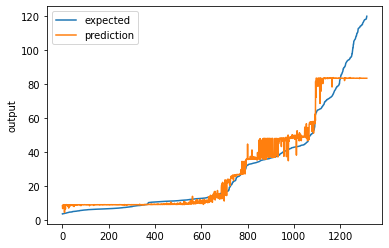

In [ ]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

        model.load_weights('best_weights_NN.hdf5')
        
        pred = model.predict(X_test)
        
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)